In [28]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tensorflow_addons as tfa
from keras.layers import Flatten, Dense, Dropout
import tifffile

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import os

import scipy
from numba import cuda 

In [2]:
# !pip install numpy tensorflow matplotlib scipy
# # !pip install pandas
# !pip install tifffile
# !pip install scikit-learn
# !pip install imagecodecs
# !pip install tensorflow-addons
# !pip install numba 

In [3]:
def reset_gpu():
    device = cuda.get_current_device()
    device.reset()

In [4]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)

In [5]:
tiles = pd.read_csv(r'Data/Tiles_expanded.csv')
tiles_expanded_rv = pd.read_csv(r'Data/Tiles_expanded_road_vector.csv').drop(['Unnamed: 0'],axis=1)
tiles_expanded_rv = pd.get_dummies(tiles_expanded_rv, columns = ['RTTYP'])

In [6]:
tiles_expanded_rv.head()

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,Bus_stop,Collisions_Future,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U
0,36,-122.514446,37.779636,-122.513306,37.778732,37.779184,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
1,37,-122.514446,37.778732,-122.513306,37.777829,37.778280,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
2,151,-122.513306,37.779636,-122.512166,37.778732,37.779184,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
3,152,-122.513306,37.778732,-122.512166,37.777829,37.778280,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
4,153,-122.513306,37.777829,-122.512166,37.776925,37.777377,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0


In [7]:
tiles_expanded_rv['Collisions_Future_binary']=tiles_expanded_rv['Collisions_Future'].apply(lambda x: 1 if x > 0 else 0)
tiles_expanded_rv['Collisions_Historical_binary']=tiles_expanded_rv['Collisions_Historical'].apply(lambda x: 1 if x > 0 else 0)

# Normalize data

In [8]:
def normalize_col(df, col_name):

    norm = (df[col_name] - df[col_name].min()) / (df[col_name].max() - df[col_name].min())
    return norm

tiles_expanded_rv['Mid_lat_norm'] = normalize_col(tiles_expanded_rv,'Mid_lat')
tiles_expanded_rv['Mid_long_norm'] = normalize_col(tiles_expanded_rv,'Mid_long')


Split into training and test

In [12]:
MODEL_TYPE='logistic' # 'linear'

if MODEL_TYPE == 'linear':
    input_x = ['Tile_ID','Collisions_Historical', 'Mid_lat_norm','Mid_long_norm', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']
    input_y = ['Collisions_Future']
elif MODEL_TYPE == 'logistic':
    input_x = ['Tile_ID','Collisions_Historical_binary', 'Mid_lat_norm','Mid_long_norm', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']
    input_y = ['Collisions_Future_binary']
    

x_train, x_test, y_train, y_test = train_test_split(
                                    tiles_expanded_rv[input_x], 
                                    tiles_expanded_rv[input_y],
                                    random_state=104, 
                                    test_size=0.20, 
                                    shuffle=True)



Model #1: Linear regression using Historical Collisions, SFMTA Street Characteristics, and Geocoordinates

## Image Pre-Processing

In [13]:
IMAGE_PATH = 'Satellite_Imagery/Satellite_Images_Tiled/' 

In [14]:
 #eda
img = tifffile.imread('Satellite_Imagery/Satellite_Images_Tiled/36.tif')[0:148, 0:188, :]
img2 = tifffile.imread('Satellite_Imagery/Satellite_Images_Tiled/37.tif')[0:148, 0:188, :]

In [15]:
# eda
print(np.shape(img2))

(148, 188, 4)


In [16]:
# eda
test = []
test.append(img[0:148, 0:188, :])
test.append(img2[0:148, 0:188, :])
print(np.shape(test))
test = np.stack(test)
print(np.shape(test))

(2, 148, 188, 4)
(2, 148, 188, 4)


In [17]:
def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    data_mini_test = []
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    for id in x_test['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini_test.append(image)
 
    # stack images and trasnform to array
    images_mini_test = np.stack(data_mini_test)
    
    return images_mini, images_mini_test

In [18]:
# THERE IS ONE FILE IN THE "SATELLITE IMAGES TILED" FOLDER THAT IS NOT A TIF IMAGE, DELETE THIS FILE
images_mini, images_mini_test = preprocess_data_part1(IMAGE_PATH)

In [19]:
np.shape(images_mini)
np.shape(images_mini_test)

(2095, 148, 188, 4)

In [19]:
# images_mini_reshaped = images_mini.reshape((8376,1,1,111296))

In [20]:
# images_mini_reshaped.shape
# len(images_mini_reshaped[0][0][0])

Street Data Pre-Processing

In [20]:
street = np.asarray(x_train[input_x[1:]]).astype('float32')
street_mini = []
for row in street:
    street_mini.append([[row]])
street_mini = np.stack(street_mini)
np.shape(street_mini)


street_test = np.asarray(x_test[input_x[1:]]).astype('float32')
street_mini_test = []
for row in street_test:
    street_mini_test.append([[row]])
street_mini_test = np.stack(street_mini_test)
np.shape(street_mini_test)

(2095, 1, 1, 11)

In [21]:
x_test.shape
images_mini_test.shape

(2095, 148, 188, 4)

In [22]:
input_image_street = np.hstack(
    (street_mini.reshape((8376,11)),
     images_mini.reshape(8376,111296))
)

In [23]:
input_image_street_test = np.hstack(
    (street_mini_test.reshape((2095,11)),
    images_mini_test.reshape((2095,148*188*4))
    ))

## Linear Regression

In [25]:
# x: 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U'
# y: 'Collisions_Future'

def create_linear_model():
    # DENSE LAYERS 
    input = tf.keras.layers.Input(shape=(111307,))

    outputs = layers.Dense(1)(input)

    linear_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="linear_model")

    linear_model.summary()

    linear_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error'
        )
    
    return linear_model

linear_model = create_linear_model()

history = linear_model.fit(
    input_image_street,
     np.stack(y_train['Collisions_Future'].to_numpy()),
    epochs=100,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)


Model: "linear_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 111307)]          0         
                                                                 
 dense (Dense)               (None, 1)                 111308    
                                                                 
Total params: 111,308
Trainable params: 111,308
Non-trainable params: 0
_________________________________________________________________


2023-03-14 04:21:15.435917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 04:21:15.442543: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 04:21:15.442895: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 04:21:15.443498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Epoch 1/100


2023-03-14 04:21:21.852801: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f7fe8028240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-14 04:21:21.852850: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla M60, Compute Capability 5.2
2023-03-14 04:21:21.859565: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-14 04:21:22.020011: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


210/210 [==============================] - 3s 11ms/step - loss: 3831688.7500 - val_loss: 4930.3271
Epoch 2/100
210/210 [==============================] - 1s 7ms/step - loss: 4564.0796 - val_loss: 2762.6865
Epoch 3/100
210/210 [==============================] - 1s 7ms/step - loss: 3515.1233 - val_loss: 2552.5735
Epoch 4/100
210/210 [==============================] - 1s 7ms/step - loss: 3159.9583 - val_loss: 2660.7402
Epoch 5/100
210/210 [==============================] - 1s 7ms/step - loss: 2338.4841 - val_loss: 2147.3416
Epoch 6/100
210/210 [==============================] - 1s 7ms/step - loss: 2533.4326 - val_loss: 1860.2889
Epoch 7/100
210/210 [==============================] - 1s 7ms/step - loss: 1830.0837 - val_loss: 1481.9592
Epoch 8/100
210/210 [==============================] - 1s 7ms/step - loss: 4353.0532 - val_loss: 3725.8889
Epoch 9/100
210/210 [==============================] - 1s 7ms/step - loss: 8742.3359 - val_loss: 34995.6523
Epoch 10/100
210/210 [======================

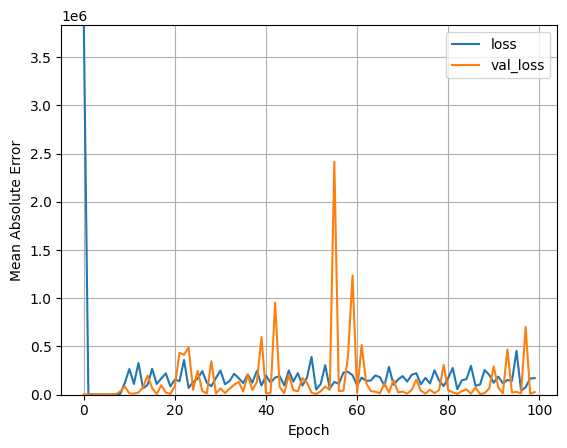

In [26]:
plot_loss(history)

In [27]:
predict_result = history.model.predict(input_image_street_test)

66/66 [==============================] - 0s 5ms/step


## Mean squared error

In [53]:
np.square(predict_result - y_test['Collisions_Future'].to_numpy().reshape((2095,1))).mean()

27614.103562516062

## LOGISTIC MODEL WITH IMAGES

In [29]:
# def log_loss(y_pred, y):
#   # Compute the log loss function
#   ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
#   return tf.reduce_mean(ce)

# class LogisticRegression(tf.Module):

#   def __init__(self):
#     self.built = False

#   def __call__(self, x, train=True):
#     # Initialize the model parameters on the first call
#     if not self.built:
#       # Randomly generate the weights and the bias term
#       rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
#       rand_b = tf.random.uniform(shape=[], seed=22)
#       self.w = tf.Variable(rand_w)
#       self.b = tf.Variable(rand_b)
#       self.built = True
#     # Compute the model output
#     z = tf.add(tf.matmul(x, self.w), self.b)
#     z = tf.squeeze(z, axis=1)
#     if train:
#       return z
#     return tf.sigmoid(z)

# log_reg = LogisticRegression()

# def predict_class(y_pred, thresh=0.5):
#   # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
#   return tf.cast(y_pred > thresh, tf.float32)

# def accuracy(y_pred, y):
#   # Return the proportion of matches between `y_pred` and `y`
#   y_pred = tf.math.sigmoid(y_pred)
#   y_pred_class = predict_class(y_pred)
#   check_equal = tf.cast(y_pred_class == y,tf.float32)
#   acc_val = tf.reduce_mean(check_equal)
#   return acc_val

In [30]:
# y_pred = log_reg(input_image_street[0:5], train=False)
# y_pred.numpy()
# # input_image_street.shape[0]

In [31]:
# # Our vectorized labels
# y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
# # y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))
# batch_size = 2 #  64
# train_dataset = tf.data.Dataset.from_tensor_slices((input_image_street, y_train))
# train_dataset = train_dataset.shuffle(buffer_size=input_image_street.shape[0]).batch(batch_size)
# # test_dataset = tf.data.Dataset.from_tensor_slices((input_image_street, y_test))
# # test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

In [32]:
# y_train.shape

In [33]:
# # Set training parameters
# epochs = 3 # 200
# learning_rate = 0.01
# train_losses, test_losses = [], []
# train_accs, test_accs = [], []

# # Set up the training loop and begin training
# for epoch in range(epochs):
#   batch_losses_train, batch_accs_train = [], []
#   batch_losses_test, batch_accs_test = [], []

#   # Iterate over the training data
#   for x_batch, y_batch in train_dataset:
#     with tf.GradientTape() as tape:
#       y_pred_batch = log_reg(x_batch)
#       # print(f'y_pred_batch: {y_pred_batch.numpy().reshape((2,1)).shape}')
#       print(f'y_batch: {y_batch.shape}')
#       y_pred_batch = y_pred_batch.numpy().reshape((2,1))
#       batch_loss = log_loss(y_pred_batch, y_batch)
#     batch_acc = accuracy(y_pred_batch, y_batch)
#     # Update the parameters with respect to the gradient calculations
#     grads = tape.gradient(batch_loss, log_reg.variables)
#     for g,v in zip(grads, log_reg.variables):
#       print(g,v)  
#       v.assign_sub(learning_rate * g)
#     # Keep track of batch-level training performance
#     batch_losses_train.append(batch_loss)
#     batch_accs_train.append(batch_acc)

#   # Iterate over the testing data
#   for x_batch, y_batch in test_dataset:
#     y_pred_batch = log_reg(x_batch)
#     batch_loss = log_loss(y_pred_batch, y_batch)
#     batch_acc = accuracy(y_pred_batch, y_batch)
#     # Keep track of batch-level testing performance
#     batch_losses_test.append(batch_loss)
#     batch_accs_test.append(batch_acc)

#   # Keep track of epoch-level model performance
#   train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
#   test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
#   train_losses.append(train_loss)
#   train_accs.append(train_acc)
#   test_losses.append(test_loss)
#   test_accs.append(test_acc)
#   if epoch % 20 == 0:
#     print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

In [34]:
# clf = LogisticRegression(random_state=0,max_iter=1000).fit(input_image_street, np.ravel(y_train))

Model: "logistic_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 111307)]          0         
                                                                 
 dense (Dense)               (None, 1)                 111308    
                                                                 
Total params: 111,308
Trainable params: 111,308
Non-trainable params: 0
_________________________________________________________________


2023-03-14 04:42:23.794074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 04:42:23.800684: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 04:42:23.801032: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 04:42:23.801693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Epoch 1/50


2023-03-14 04:42:30.474129: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f89a60f3a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-14 04:42:30.474174: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla M60, Compute Capability 5.2
2023-03-14 04:42:30.480286: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-14 04:42:30.640000: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


210/210 [==============================] - 3s 9ms/step - loss: 534.9476 - accuracy: 0.6848 - val_loss: 202.9917 - val_accuracy: 0.8043
Epoch 2/50
210/210 [==============================] - 2s 7ms/step - loss: 361.7238 - accuracy: 0.7055 - val_loss: 327.1791 - val_accuracy: 0.3920
Epoch 3/50
210/210 [==============================] - 2s 8ms/step - loss: 394.3917 - accuracy: 0.7194 - val_loss: 177.5089 - val_accuracy: 0.6426
Epoch 4/50
210/210 [==============================] - 2s 7ms/step - loss: 212.8718 - accuracy: 0.7284 - val_loss: 378.5093 - val_accuracy: 0.8085
Epoch 5/50
210/210 [==============================] - 2s 7ms/step - loss: 278.1451 - accuracy: 0.7442 - val_loss: 172.9765 - val_accuracy: 0.8091
Epoch 6/50
210/210 [==============================] - 2s 7ms/step - loss: 479.4064 - accuracy: 0.7143 - val_loss: 888.8353 - val_accuracy: 0.8091
Epoch 7/50
210/210 [==============================] - 2s 7ms/step - loss: 329.5608 - accuracy: 0.7522 - val_loss: 257.5073 - val_accura

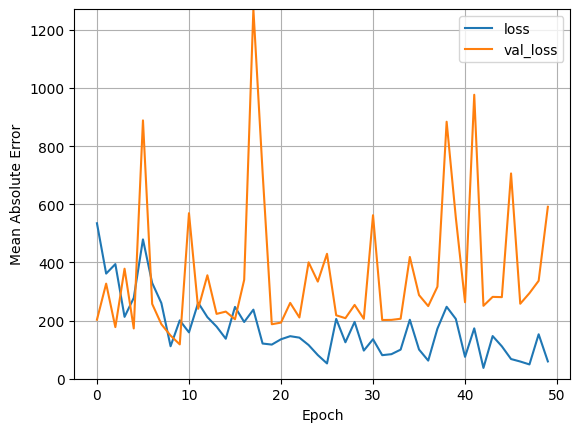

In [25]:
# x: 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U'
# y: 'Collisions_Future'

def create_logistic_model():
    # DENSE LAYERS 
    input = tf.keras.layers.Input(shape=(111307,))
    
    # input = keras.layers.Flatten()(input)

    outputs = keras.layers.Dense(units = 1, activation = 'sigmoid')(input)

    log_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="logistic_model")

    log_model.summary()

    log_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="bce",
        metrics=['accuracy']
        )
    
    return log_model

logistic_model = create_logistic_model()

# class_weight = {0: 1,
#                 1: 100000,
#                 2: 100000,
#                 3: 100000,
#                 4: 100000,
#                 5: 100000,
#                 6: 100000,
#                 7: 100000,
#                 8: 100000,
#                 9: 100000,
#                 10: 100000,
#                 #11: 100000,
#                }

history = logistic_model.fit(
    input_image_street,
    np.stack(y_train.to_numpy()),
     # y_train_2,
    epochs=50,
    # Suppress logging.
     # verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    # class_weight = class_weight
    )

plot_loss(history)

In [26]:
predict_result = history.model.predict(input_image_street_test)

66/66 [==============================] - 0s 5ms/step


In [44]:
predict_result = pd.Series(predict_result.reshape(2095)).apply(lambda x: 1 if x > 0 else 0)

In [45]:
f1_score(y_test.to_numpy(), predict_result, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')

0.026030368763557486